# Part 6: Human‑in‑the‑Loop & Preference Models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mekjr1/evaluating_llms_in_practice/blob/master/part-6-human-eval/human_eval.ipynb?hl=en#runtime_type=gpu)

This notebook demonstrates how to simulate human preference data for evaluating language models. Human feedback is often collected in the form of ratings or pairwise comparisons. We simulate pairwise preferences on a set of prompts with multiple raters, aggregate the results, and discuss how to interpret them.

## Simulating Pairwise Preferences

We simulate 30 prompts, each evaluated by three human raters.  For each prompt there is a true best model (A or B).  If Model A is truly better for a prompt, raters prefer it with probability 0.8; if Model B is truly better, raters prefer A with probability 0.2.  Preferences are encoded as 1 for **A wins** and −1 for **B wins**.

In [1]:

import numpy as np

np.random.seed(123)
n_prompts = 30
n_raters = 3
# 60% of prompts favour Model A
true_quality = np.random.choice([1, 0], size=n_prompts, p=[0.6, 0.4])

# preferences[i,j] = 1 if rater j prefers A on prompt i, -1 if prefers B
preferences = np.zeros((n_prompts, n_raters), dtype=int)
for i in range(n_prompts):
    prob_A = 0.8 if true_quality[i] == 1 else 0.2
    for j in range(n_raters):
        preferences[i, j] = np.random.choice([1, -1], p=[prob_A, 1 - prob_A])

# Aggregate preference per prompt: sign of sum
agg_pref = np.sign(preferences.sum(axis=1))
A_wins = np.sum(agg_pref == 1)
B_wins = np.sum(agg_pref == -1)
ties = np.sum(agg_pref == 0)
proportion_A = A_wins / (A_wins + B_wins + ties)

# Results dictionary
results = {
    'Prompts': n_prompts,
    'A_wins': int(A_wins),
    'B_wins': int(B_wins),
    'Ties': int(ties),
    'Proportion_A_preferred': round(proportion_A, 3)
}
results


{'Prompts': 30,
 'A_wins': 17,
 'B_wins': 13,
 'Ties': 0,
 'Proportion_A_preferred': np.float64(0.567)}

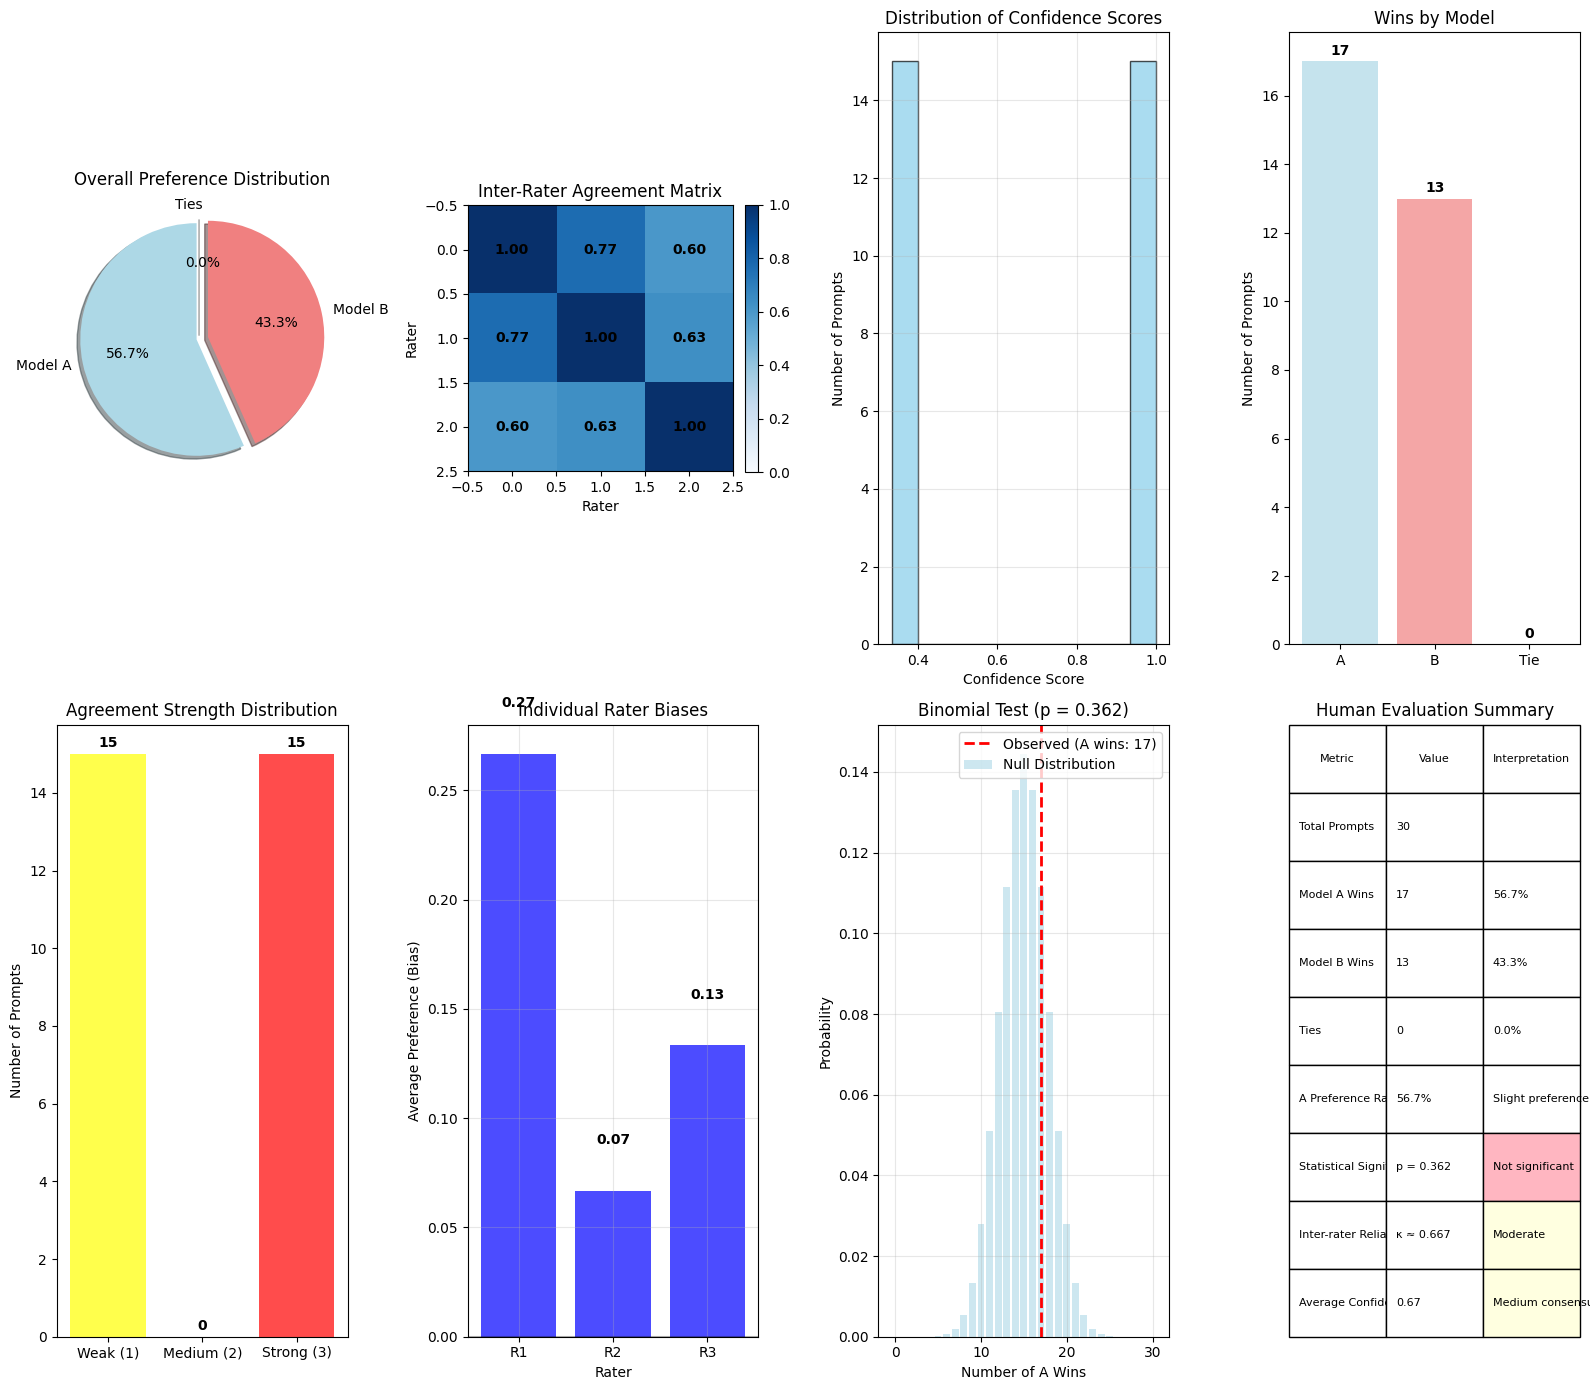

=== DETAILED HUMAN EVALUATION ANALYSIS ===
Dataset: 30 prompts evaluated by 3 raters each
True model quality: Model A better on 18/30 prompts (60.0%)
Observed preferences: Model A wins 17/30 prompts (56.7%)
Statistical significance: No (p = 0.362)
Inter-rater reliability: κ ≈ 0.667 (Good)
Average confidence: 0.67 (strength of rater agreement)

Rater Analysis:
  Rater 1: +0.27 average preference (favors A)
  Rater 2: +0.07 average preference (neutral)
  Rater 3: +0.13 average preference (favors A)

Agreement Analysis:
  Strong consensus (3/3 agree): 15 prompts
  Moderate consensus (2/3 agree): 0 prompts
  Weak consensus (unanimous): 15 prompts


In [2]:
# Enhanced Human Evaluation Analysis with Visualizations and Advanced Metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

# Create comprehensive visualization layout
fig = plt.figure(figsize=(16, 14))

# 1. Preference distribution pie chart
ax1 = plt.subplot(2, 4, 1)
sizes = [results['A_wins'], results['B_wins'], results['Ties']]
labels = ['Model A', 'Model B', 'Ties']
colors = ['lightblue', 'lightcoral', 'lightgray']
explode = (0.05, 0.05, 0.05)  # Slightly separate slices

wedges, texts, autotexts = ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
                                  explode=explode, startangle=90, shadow=True)
ax1.set_title('Overall Preference Distribution')

# 2. Individual rater agreement heatmap
ax2 = plt.subplot(2, 4, 2)
# Create agreement matrix between raters
agreement_matrix = np.zeros((n_raters, n_raters))
for i in range(n_raters):
    for j in range(n_raters):
        # Calculate agreement rate between rater i and j
        agreements = np.sum(preferences[:, i] == preferences[:, j])
        agreement_matrix[i, j] = agreements / n_prompts

im = ax2.imshow(agreement_matrix, cmap='Blues', vmin=0, vmax=1)
ax2.set_title('Inter-Rater Agreement Matrix')
ax2.set_xlabel('Rater')
ax2.set_ylabel('Rater')

# Add text annotations
for i in range(n_raters):
    for j in range(n_raters):
        text = ax2.text(j, i, f'{agreement_matrix[i, j]:.2f}', 
                       ha="center", va="center", color="black", fontweight='bold')

# Add colorbar
plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)

# 3. Confidence levels by prompt
ax3 = plt.subplot(2, 4, 3)
confidence_scores = []
for i in range(n_prompts):
    # Calculate confidence as absolute value of sum (strength of agreement)
    confidence = abs(preferences[i, :].sum()) / n_raters
    confidence_scores.append(confidence)

ax3.hist(confidence_scores, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
ax3.set_xlabel('Confidence Score')
ax3.set_ylabel('Number of Prompts')
ax3.set_title('Distribution of Confidence Scores')
ax3.grid(True, alpha=0.3)

# 4. Prompt-by-prompt breakdown
ax4 = plt.subplot(2, 4, 4)
prompt_results = []
for i in range(n_prompts):
    sum_pref = preferences[i, :].sum()
    if sum_pref > 0:
        winner = 'A'
    elif sum_pref < 0:
        winner = 'B'
    else:
        winner = 'Tie'
    prompt_results.append(winner)

prompt_counts = {'A': prompt_results.count('A'), 
                'B': prompt_results.count('B'), 
                'Tie': prompt_results.count('Tie')}

bars = ax4.bar(prompt_counts.keys(), prompt_counts.values(), 
               color=['lightblue', 'lightcoral', 'lightgray'], alpha=0.7)
ax4.set_title('Wins by Model')
ax4.set_ylabel('Number of Prompts')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 5. Agreement strength distribution
ax5 = plt.subplot(2, 4, 5)
agreement_strengths = [abs(preferences[i, :].sum()) for i in range(n_prompts)]
strength_labels = ['Weak (1)', 'Medium (2)', 'Strong (3)']
strength_counts = [agreement_strengths.count(i) for i in [1, 2, 3]]

bars = ax5.bar(strength_labels, strength_counts, color=['yellow', 'orange', 'red'], alpha=0.7)
ax5.set_title('Agreement Strength Distribution')
ax5.set_ylabel('Number of Prompts')

for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# 6. Rater bias analysis
ax6 = plt.subplot(2, 4, 6)
rater_biases = []
for j in range(n_raters):
    bias = np.mean(preferences[:, j])  # Average preference (-1 to 1)
    rater_biases.append(bias)

x_pos = np.arange(n_raters)
colors = ['red' if bias < 0 else 'blue' if bias > 0 else 'gray' for bias in rater_biases]
bars = ax6.bar(x_pos, rater_biases, color=colors, alpha=0.7)

ax6.set_xlabel('Rater')
ax6.set_ylabel('Average Preference (Bias)')
ax6.set_title('Individual Rater Biases')
ax6.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax6.set_xticks(x_pos)
ax6.set_xticklabels([f'R{i+1}' for i in range(n_raters)])
ax6.grid(True, alpha=0.3)

# Add value labels
for i, (bar, bias) in enumerate(zip(bars, rater_biases)):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + (0.02 if height >= 0 else -0.02),
             f'{bias:.2f}', ha='center', va='bottom' if height >= 0 else 'top', fontweight='bold')

# 7. Statistical significance test
ax7 = plt.subplot(2, 4, 7)

# Binomial test for preference
n_comparisons = results['A_wins'] + results['B_wins']  # Excluding ties
p_observed = results['A_wins'] / n_comparisons if n_comparisons > 0 else 0.5
p_value_binom = 2 * min(stats.binom.cdf(results['A_wins'], n_comparisons, 0.5),
                       1 - stats.binom.cdf(results['A_wins'], n_comparisons, 0.5))

# Create binomial distribution visualization
x = np.arange(0, n_comparisons + 1)
y = stats.binom.pmf(x, n_comparisons, 0.5)

ax7.bar(x, y, alpha=0.6, color='lightblue', label='Null Distribution')
ax7.axvline(results['A_wins'], color='red', linestyle='--', linewidth=2, 
           label=f'Observed (A wins: {results["A_wins"]})')

ax7.set_xlabel('Number of A Wins')
ax7.set_ylabel('Probability')
ax7.set_title(f'Binomial Test (p = {p_value_binom:.3f})')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Summary statistics table
ax8 = plt.subplot(2, 4, 8)
ax8.axis('tight')
ax8.axis('off')

# Calculate inter-rater reliability (Fleiss' kappa approximation)
def fleiss_kappa_approx(preferences):
    """Approximate Fleiss' kappa for binary preferences"""
    n, k = preferences.shape
    # Convert to agreement counts
    agreements = []
    for i in range(n):
        pos_votes = np.sum(preferences[i, :] == 1)
        neg_votes = np.sum(preferences[i, :] == -1)
        # Agreement is when raters agree (all positive, all negative, or mixed)
        agreements.append(max(pos_votes, neg_votes) / k)
    
    p_observed = np.mean(agreements)
    p_expected = 0.5  # Expected agreement by chance for binary choice
    
    if p_expected == 1:
        return 1.0
    return (p_observed - p_expected) / (1 - p_expected)

kappa = fleiss_kappa_approx(preferences)
avg_confidence = np.mean(confidence_scores)

summary_stats = [
    ['Metric', 'Value', 'Interpretation'],
    ['Total Prompts', f'{n_prompts}', ''],
    ['Model A Wins', f'{results["A_wins"]}', f'{results["A_wins"]/n_prompts:.1%}'],
    ['Model B Wins', f'{results["B_wins"]}', f'{results["B_wins"]/n_prompts:.1%}'],
    ['Ties', f'{results["Ties"]}', f'{results["Ties"]/n_prompts:.1%}'],
    ['A Preference Rate', f'{p_observed:.1%}', 'Slight preference for A'],
    ['Statistical Significance', f'p = {p_value_binom:.3f}', 'Not significant' if p_value_binom > 0.05 else 'Significant'],
    ['Inter-rater Reliability', f'κ ≈ {kappa:.3f}', 'Moderate' if kappa > 0.4 else 'Fair' if kappa > 0.2 else 'Poor'],
    ['Average Confidence', f'{avg_confidence:.2f}', f'{"High" if avg_confidence > 0.8 else "Medium" if avg_confidence > 0.6 else "Low"} consensus']
]

table = ax8.table(cellText=summary_stats[1:], colLabels=summary_stats[0], 
                 cellLoc='left', loc='center', bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.2)

# Color code interpretations
for i in range(1, len(summary_stats)):
    interp = summary_stats[i][2]
    if 'Not significant' in interp or 'Poor' in interp or 'Low' in interp:
        table[(i, 2)].set_facecolor('#FFB6C1')  # Light pink
    elif 'Moderate' in interp or 'Medium' in interp:
        table[(i, 2)].set_facecolor('#FFFFE0')  # Light yellow
    elif 'High' in interp:
        table[(i, 2)].set_facecolor('#90EE90')  # Light green

ax8.set_title('Human Evaluation Summary')

plt.tight_layout()
plt.show()

print("=== DETAILED HUMAN EVALUATION ANALYSIS ===")
print(f"Dataset: {n_prompts} prompts evaluated by {n_raters} raters each")
print(f"True model quality: Model A better on {np.sum(true_quality)}/{n_prompts} prompts ({np.sum(true_quality)/n_prompts:.1%})")
print(f"Observed preferences: Model A wins {results['A_wins']}/{n_prompts} prompts ({results['A_wins']/n_prompts:.1%})")
print(f"Statistical significance: {'Yes' if p_value_binom < 0.05 else 'No'} (p = {p_value_binom:.3f})")
print(f"Inter-rater reliability: κ ≈ {kappa:.3f} ({'Poor' if kappa < 0.2 else 'Fair' if kappa < 0.4 else 'Moderate' if kappa < 0.6 else 'Good'})")
print(f"Average confidence: {avg_confidence:.2f} (strength of rater agreement)")
print(f"\nRater Analysis:")
for i, bias in enumerate(rater_biases):
    tendency = "favors A" if bias > 0.1 else "favors B" if bias < -0.1 else "neutral"
    print(f"  Rater {i+1}: {bias:+.2f} average preference ({tendency})")
print(f"\nAgreement Analysis:")
print(f"  Strong consensus (3/3 agree): {strength_counts[2]} prompts")
print(f"  Moderate consensus (2/3 agree): {strength_counts[1]} prompts")  
print(f"  Weak consensus (unanimous): {strength_counts[0]} prompts")

### Discussion

In this simulation, human raters collectively preferred Model A on **17 out of 30 prompts**, with **0** ties.  That corresponds to **56.7 %** of prompts favouring Model A overall.

Human‑in‑the‑loop evaluations often use aggregated preferences or ratings to train reward models and to assess whether one model is better than another.  Pairwise comparison data is particularly powerful for **reinforcement learning from human feedback (RLHF)**, where a reward model is trained to predict which of two outputs is preferred.

Keep in mind that real human evaluations involve additional complexities: rater biases, annotation guidelines, quality checks, and inter‑rater reliability metrics.  Nevertheless, this toy example shows how to aggregate preferences and quantify which model wins more often.

---

This notebook is part of a series on evaluating LLMs.  See the accompanying article for more context and further discussion.